In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas_datareader import data as pdr
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from math import sqrt
from keras.models import Sequential
from keras.layers import Dense,LSTM


In [3]:
yf.pdr_override()


In [4]:
ticker = "AAPL"
start_date = "2020-01-01"
end_date = "2021-01-01"
stock_data = pdr.get_data_yahoo(ticker, start=start_date, end=end_date)

[*********************100%***********************]  1 of 1 completed


In [5]:
closing_price = stock_data['Close']


In [17]:
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(closing_price.values.reshape(-1,1))

In [18]:
train_size = int(len(scaled_data)*0.8)
train_data,test_data = scaled_data[0:train_size,:],scaled_data[train_size:,:]
test_data_index = closing_price[train_size:].index

In [19]:
def create_dataset(dataset,windoqw_size=1):
  data_x,data_y = [],[]
  for i in range(len(dataset)-window_size-1):
    data_x.append(dataset[i:(i+window_size),0])
    data_y.append(dataset[i+window_size,0])
  return np.array(data_x),np.array(data_y)

In [20]:
window_size = 5
train_x,train_y = create_dataset(train_data,window_size)
test_x,test_y = create_dataset(test_data,window_size)

In [21]:
# Reshape the input to be [samples, time steps, features]
train_x = np.reshape(train_x, (train_x.shape[0], 1, train_x.shape[1]))
test_x = np.reshape(test_x, (test_x.shape[0], 1, test_x.shape[1]))

In [23]:
model = Sequential()
model.add(LSTM(50,input_shape=(1,window_size)))

model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

In [24]:
model.fit(train_x, train_y, epochs=100, batch_size=1, verbose=0)

In [25]:
train_predict = model.predict(train_x)
test_predict = model.predict(test_x)

2/2 [==============================] - 0s 7ms/step


In [26]:
train_predict = scaler.inverse_transform(train_predict)
train_y = scaler.inverse_transform([train_y])
test_predict = scaler.inverse_transform(test_predict)
test_y = scaler.inverse_transform([test_y])

In [27]:
test_rmse = sqrt(mean_squared_error(test_y[0], test_predict[:, 0]))
print("LSTM Test RMSE: ", test_rmse)

LSTM Test RMSE:  2.7205557632053297


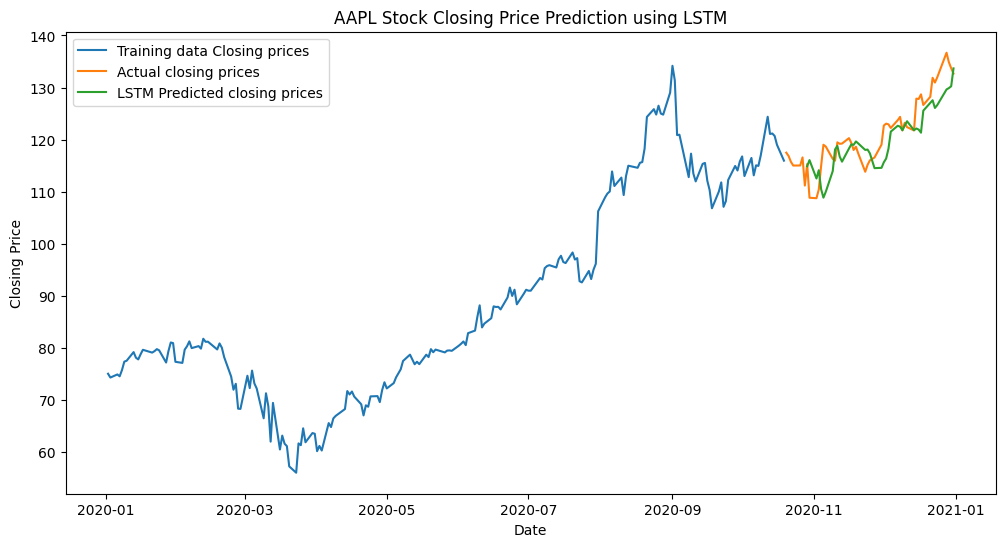

In [29]:
plt.figure(figsize=(12, 6))
plt.plot(closing_price[:-len(test_data_index)], label="Training data Closing prices")
plt.plot(closing_price[-len(test_data_index):], label="Actual closing prices")
plt.plot(test_data_index[7:], test_predict[:-1], label="LSTM Predicted closing prices")
plt.xlabel("Date")
plt.ylabel("Closing Price")
plt.title(f"{ticker} Stock Closing Price Prediction using LSTM")
plt.legend()
plt.show()